<a href="https://colab.research.google.com/github/tsaw8/Thinkful_Project/blob/master/Hybrid_Approach_to_Product_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Product Recommendation for Ecommerce Website

## Problem Description 
According to Statista, over 4.33 billion people access the internet globally. Many service providers and retailers have moved online and the popularity of ecommerce platforms continue to rise . Unlike physical stores, online retailers are not restricted to limited shelf space. Retailers are able to sell a wide variety of products online because the costs of logistics is lower. However, the huge amount of goods available makes it difficult for customers to navigate through their product of interest. To influence the user’s buying decision and increase the company’s revenue, we will create a product recommender system to provide a suggested list of items with the current item being viewed.

## Dataset Overview
Retailrocket, a service provider that creates product recommendation engine for eCommerce platform, has released data from a real-world ecommerces website on Kaggle. 

The dataset contains three tables: 

1. Events: captures visitors’ behavioral data that was collected over 4.5 months in 2015 
 - Visitor can perform three types of events: view, add-to-cart, or transaction
 - There are 2,756,101 events and 1,407, 580 unique visitors

2. Item Properties: provides a concatenated snapshots of  417,053 unique items for every week during the collection period
 - Consists of four columns (timestamp, itemid, property, and value)
 - There is a total of 20,275,902 rows of item properties
 - All values of properties were hashed, except ‘categoryid’ and ‘available’

3. Category Tree: consists of 1,669 rows and two columns with a categoryid and its corresponding parentid
 - Not all categoryid have a parentid

## Methodology
#### Data Preprocessing 
As mentioned above, item properties are hashed due to privacy issues, which makes it difficult to interpret results if a content-based approach was taken. Instead, we can recommend item pairs that were purchased by previous customers from the events table. With the assumption that the data is sparse, we could clean the data by removing users with no activity and items with only a single view or activity. 

#### Model
LightFM is a python recommendation algorithm that can work with the implicit feedback in our dataset. It also incorporates item and user properties of collaborative filtering into a matrix factorization to reduce dimensionality. We would also need to construct an user-item or item-property matrix that would be used for train and test split. 

#### Evaluation 
We will use classification accuracy metrics, like ROC AUC, to assess the recommendation algorithm ability classifying relevant and irrelevant items. Recall will be weighted more than precision since we are most interested in the probability that a relevant item is recommended.


## Import the Dependencies

In [0]:
!pip install -q lightfm

In [0]:
# Data processing  
import numpy as np
import pandas as pd 

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing
from scipy.sparse import csr_matrix
import scipy.sparse as sp
from scipy.sparse import vstack
from scipy import sparse
from scipy.sparse.linalg import spsolve

# Model
from subprocess import check_output
from sklearn.model_selection import train_test_split

from lightfm import LightFM
import scipy.sparse as sp
from scipy.sparse import vstack

# Other tools 
import os 
import operator
from datetime import *

In [0]:
# Python tools
#import surprise 
#import implicit
#import LightFM
#import pyspark.ml.recommendation

## Load the Data

In [0]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Check for data 
!ls '/content/gdrive/My Drive/Colab Datasets/ecommerce_data'

 category_tree.csv
'E-Commerce Recommender System.ipynb'
 events.csv
'Hybrid Approach to Product Recommendation.ipynb'
 item_properties_part1.csv
 item_properties_part2.csv


In [0]:
# Create path for files 
events = pd.read_csv('/content/gdrive/My Drive/Colab Datasets/ecommerce_data/events.csv')
category_tree = pd.read_csv('/content/gdrive/My Drive/Colab Datasets/ecommerce_data/category_tree.csv')
item_prop_1 = pd.read_csv('/content/gdrive/My Drive/Colab Datasets/ecommerce_data/item_properties_part1.csv')
item_prop_2 = pd.read_csv('/content/gdrive/My Drive/Colab Datasets/ecommerce_data/item_properties_part2.csv')

First, let's take a look at the events table. 

In [0]:
# Format timestamp
events['timestamp'] = events['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000))
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 05:02:12.117,257597,view,355908,NaN
1,2015-06-02 05:50:14.164,992329,view,248676,NaN
2,2015-06-02 05:13:19.827,111016,view,318965,NaN
3,2015-06-02 05:12:35.914,483717,view,253185,NaN
4,2015-06-02 05:02:17.106,951259,view,367447,NaN


In [0]:
# Shape
events.shape

(2756101, 5)

In [0]:
# Statistics
events.describe(include='all')

,timestamp,visitorid,event,itemid,transactionid
count,2756101,2.756101e+06,2756101,2.756101e+06,22457.000000
unique,2750455,NaN,3,NaN,NaN
top,2015-06-17 19:13:47.120000,NaN,view,NaN,NaN
freq,6,NaN,2664312,NaN,NaN
first,2015-05-03 03:00:04.384000,NaN,NaN,NaN,NaN
last,2015-09-18 02:59:47.788000,NaN,NaN,NaN,NaN
mean,NaN,7.019229e+05,NaN,2.349225e+05,8826.497796
std,NaN,4.056875e+05,NaN,1.341954e+05,5098.996290
min,NaN,0.000000e+00,NaN,3.000000e+00,0.000000
25%,NaN,3.505660e+05,NaN,1.181200e+05,4411.000000


In [0]:
# All visitors
print('Total visitors:', events['visitorid'].size)

# Unique visitors
print('Unique visitor_ids:', events['visitorid'].nunique())

Total visitors: 2756101
Unique visitor_ids: 1407580


__Observation__: The data was collected from June to September in 2015. The events table contains over 2.7 million rows and more than 1.4 million unique visitors. Most visitors view products. 

Next, we'll merge the item property tables and convert timestamp to datetime format. 

In [0]:
# Merge items tables 
items = pd.concat([item_prop_1,item_prop_2])

In [0]:
# Format timestamp
items['timestamp'] = items['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000))
items.head()

,timestamp,itemid,property,value
0,2015-06-28 03:00:00,460429,categoryid,1338
1,2015-09-06 03:00:00,206783,888,1116713 960601 n277.200
2,2015-08-09 03:00:00,395014,400,n552.000 639502 n720.000 424566
3,2015-05-10 03:00:00,59481,790,n15360.000
4,2015-05-17 03:00:00,156781,917,828513


In [0]:
# Shape
items.shape

(20275902, 4)

In [0]:
# Statistics
items.describe(include='all')

,timestamp,itemid,property,value
count,20275902,2.027590e+07,20275902,20275902
unique,18,NaN,1104,1966868
top,2015-05-10 03:00:00,NaN,888,769062
freq,3012756,NaN,3000398,1537247
first,2015-05-10 03:00:00,NaN,NaN,NaN
last,2015-09-13 03:00:00,NaN,NaN,NaN
mean,NaN,2.333904e+05,NaN,NaN
std,NaN,1.348452e+05,NaN,NaN
min,NaN,0.000000e+00,NaN,NaN
25%,NaN,1.165160e+05,NaN,NaN


In [0]:
# All items
print('Total items:', items['itemid'].size)

# Unique items
print('Unique item_ids:', items['itemid'].nunique())

Total items: 20275902
Unique item_ids: 417053


__Observation__: The collection time of the items property data corresponds to the previous table. There are over 20 million entries of 417,053 unique items. The specific property and value description were possibily hashed due to privacy issues. 

Now, we'll take a look at the category tree table. 

In [0]:
category_tree.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [0]:
# Shape
category_tree.shape

(1669, 2)

In [0]:
# Statistics
category_tree.describe(include='all')

,categoryid,parentid
count,1669.000000,1644.000000
mean,849.285201,847.571168
std,490.195116,505.058485
min,0.000000,8.000000
25%,427.000000,381.000000
50%,848.000000,866.000000
75%,1273.000000,1291.000000
max,1698.000000,1698.000000


In [0]:
# Unique ids
print('Unique category_ids:', category_tree['categoryid'].nunique())
print('Unique parent_ids:', category_tree['parentid'].nunique())

Unique category_ids: 1669
Unique parent_ids: 362


## Exploratory Data Analysis 
In this section, we'll explore user preference and focus on item ratings.


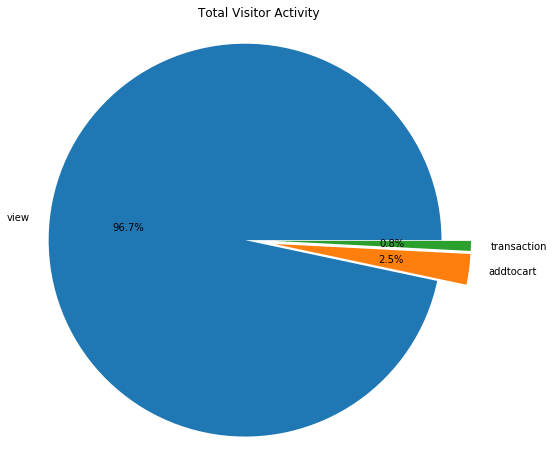

In [0]:
# Pie chart of events 
data = events.event.value_counts()
labels = data.index
sizes = data.values
explode = (0, 0.15, 0.15)  # explode 1st slice
plt.subplots(figsize=(8,8))

# Plot
plt.pie(sizes, explode=explode, labels=labels,autopct='%1.1f%%', shadow=False, startangle=0)
plt.title('Total Visitor Activity')
plt.axis('equal')
plt.show()

__How many unique customers made a purchased ?__

In [0]:
made_purchase = events[events.transactionid.notnull()].visitorid.unique()
print('There were {} unique customers that made a purchase.'.format(made_purchase.size))

There were 11719 unique customers that made a purchase.


__In the items table, how many items are available?__

In [0]:
available_items = items.loc[items.property.isin(['categoryid','available']),:]
print('Items with a categoryID and listed as an available property:', available_items.size)

Items with a categoryID and listed as an available property: 9167412


Next, let's take a look at the events and items table together.

In [0]:
# Group itemID by event type and create a list of each type
item_event_group = events.groupby('event')['itemid'].apply(list)
item_event_group

event
addtocart      [5206, 10572, 255275, 356475, 312728, 63312, 1...
transaction    [356475, 15335, 81345, 150318, 310791, 54058, ...
view           [355908, 248676, 318965, 253185, 367447, 22556...
Name: itemid, dtype: object

In [0]:
# Function to plot top k items 
def item_event_plot(event, k, title, xlabel, ylabel):
  # Create dictionary for key value pair
  count_event = {}

  # Convert event list to numpy array 
  event = np.array(event[:])

  # Count unique values of event 
  unique, counts = np.unique(event, return_counts=True)

  # Convert unique and counts to a dictionary(key: unique, values: counts)
  count_event = dict(zip(unique, counts))

  # Sort dictionary
  sort_count_event = sorted(count_event.items(), key = operator.itemgetter(1), reverse=True)

  # Variables for bargraph 
  x = [i[0] for i in sort_count_event[:int(k)]]
  y = [i[1] for i in sort_count_event[:int(k)]]
  ax = sns.barplot(x,y, order=x).set_title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

__What were the most viewed items?__

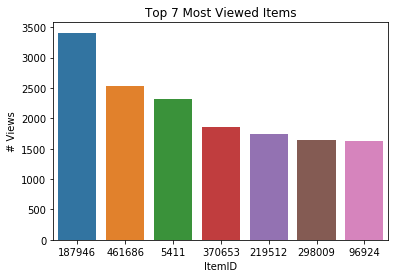

In [0]:
# Plot most viewed item
views = item_event_group['view']
item_event_plot(views, 7, 'Top 7 Most Viewed Items', 'ItemID', '# Views')

__Which were the most added to cart items?__

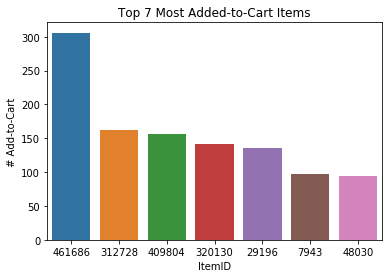

In [0]:
# Plot most add to cart item
addtocart = item_event_group['addtocart']
item_event_plot(addtocart, 7, 'Top 7 Most Added-to-Cart Items', 'ItemID', '# Add-to-Cart')


__Which items were best sellers?__

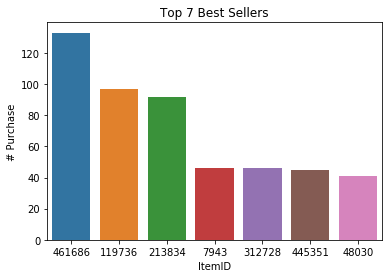

In [0]:
# Plot most purchased item
transaction = item_event_group['transaction']
item_event_plot(transaction, 7, 'Top 7 Best Sellers', 'ItemID', '# Purchase')


### Transforming the Data
In this section, we will guide new customers on their buying journey by recommending a list of items of what previous customers purchased with the current item the new customer is viewing. 

We will transform the data and create a user-item and item-property matrix for modeling. 

Let's begin cleaning the data with the following steps:
1. Create item rating by counting each activity per item
2. Remove items with single activity (i.g. only view)
3. Remove users without activity 
4. Assign new item ids and user ids

In [0]:
# Create User-Activity table 
user_activity_count = dict()
for row in events.itertuples():
    if row.visitorid not in user_activity_count:
        user_activity_count[row.visitorid] = {'view':0 , 'addtocart':0, 'transaction':0};
    if row.event == 'addtocart':
        user_activity_count[row.visitorid]['addtocart'] += 1 
    elif row.event == 'transaction':
        user_activity_count[row.visitorid]['transaction'] += 1
    elif row.event == 'view':
        user_activity_count[row.visitorid]['view'] += 1 

user_activity = pd.DataFrame(user_activity_count)
user_activity = user_activity.transpose() # change columns to activities and rows to visitorid

# Total activity feature 
user_activity['activity'] = user_activity['view'] + user_activity['addtocart'] + user_activity['transaction']
user_activity.head()

,view,addtocart,transaction,activity
257597,2,0,0,2
992329,30,0,0,30
111016,2,0,0,2
483717,3,0,0,3
951259,1,0,0,1


In [0]:
user_activity.shape

(1407580, 4)

In [0]:
# Remove users with less than 1 activity 
clean_user_activity = user_activity[user_activity['activity']>1]

In [0]:
clean_user_activity.shape

(406020, 4)

In [0]:
users_lost = round(((user_activity.shape[0]-clean_user_activity.shape[0])/user_activity.shape[0])*100)
print('Lost {}% of users after dropping users with less than 1 activity'.format(users_lost))

Lost 71% of users after dropping users with less than 1 activity


Now, we will map item ids to the users in the user activity table.

In [0]:
# Create all users and all items set
all_users = set(clean_user_activity.index.values)
all_items = set(events['itemid'])

# Map itemid to visitorid 
visitorid_to_index_mapping  = {}
itemid_to_index_mapping  = {}
vid = 0
iid = 0
for row in events.itertuples():
    if row.visitorid in all_users and row.visitorid not in visitorid_to_index_mapping:
        visitorid_to_index_mapping[row.visitorid] = vid
        vid = vid + 1

    if row.itemid in all_items and row.itemid not in itemid_to_index_mapping:
        itemid_to_index_mapping[row.itemid] = iid
        iid = iid + 1

### Construct User-Item Matrix

In [0]:
# Create user-item matrix
n_users = len(all_users)
n_items = len(all_items)
user_to_item_matrix = sp.dok_matrix((n_users, n_items), dtype=np.int8) # Dictionary Of Keys based sparse matrix

In [0]:
# Add weights to action 
action_weights = [1,2,3]

for row in events.itertuples():
    if row.visitorid not in all_users:
        continue
    
    mapped_visitor_id = visitorid_to_index_mapping[row.visitorid]
    mapped_item_id    = itemid_to_index_mapping[row.itemid]
    
    value = 0
    if row.event == 'view':
        value = action_weights[0]
    elif row.event == 'addtocart':
        value = action_weights[1]        
    elif row.event == 'transaction':
        value = action_weights[2]
        
    current_value = user_to_item_matrix[mapped_visitor_id, mapped_item_id]
    if value > current_value:
        user_to_item_matrix[mapped_visitor_id, mapped_item_id] = value
        
user_to_item_matrix = user_to_item_matrix.tocsr() # Return a copy of this matrix in Compressed Sparse Row format

In [0]:
user_to_item_matrix.shape

(406020, 235061)

In [0]:
sparsity = float(len(user_to_item_matrix.nonzero()[0]))
sparsity /= (user_to_item_matrix.shape[0] * user_to_item_matrix.shape[1])
sparsity *= 100
print (sparsity)

### Construct Item-Property Matrix

In [0]:
# Remove items that are not assoicated with events
filtered_items = items[items.itemid.isin(all_items)]

Since only 90% of item properties are associated with items in the event tables, we will create fake properties for ones that do not have an associated profile. 

In [0]:
# Create fake property for filtered items that do not have properties
fake_itemid = []
fake_timestamp = []
fake_property = []
fake_value = []
all_items_with_property = set(items.itemid)
for itx in list(all_items):
    if itx not in all_items_with_property:
        fake_itemid.insert(0, itx)
        fake_timestamp.insert(0, 0)
        fake_property.insert(0, 888)
        fake_value.insert(0, 0)
    
fake_property_dict = {'itemid':fake_itemid, 'timestamp':fake_timestamp, 'property':fake_property,
                     'value':fake_value}

fake_df = pd.DataFrame(fake_property_dict, columns=filtered_items.columns.values)
filtered_items = pd.concat([filtered_items, fake_df])

In [0]:
# Map itemid to index 
filtered_items['itemid'] = filtered_items['itemid'].apply(lambda x: itemid_to_index_mapping[x])

In [0]:
filtered_items = filtered_items.drop_duplicates(['itemid','property'])

In [0]:
filtered_items.head()

,timestamp,itemid,property,value
0,2015-06-28 03:00:00,60726,categoryid,1338
1,2015-09-06 03:00:00,135140,888,1116713 960601 n277.200
2,2015-08-09 03:00:00,128565,400,n552.000 639502 n720.000 424566
3,2015-05-10 03:00:00,41456,790,n15360.000
4,2015-05-17 03:00:00,42419,917,828513


In [0]:
# Unique value properties 
filtered_items['value'].nunique()

910481

In [0]:
# Top unique value properites
filtered_items['value'].value_counts().nlargest(10)

769062                 753348
1285872                185246
679677                 185246
519769                 185246
0                      135245
1116693                 80994
1                       50733
0                       49815
150169 610517           27113
150169 274770 79212     26653
Name: value, dtype: int64

In [0]:
#filtered_items.sort_values('timestamp', ascending=False)
#filtered_items.sort_values(by='itemid', inplace=True)

In [0]:
item_to_property_matrix = filtered_items.pivot(index='itemid', columns='property', values='value')

In [0]:
item_to_property_matrix.shape

(235061, 1099)

__Filter Properties__ <br>
Due to the large number of unique values and limited information regarding them, we will filter out items with value counts less than 100 occurances. Then, we will use One Hot Encoding to prepare value property for modeling. 

In [0]:
# Filter for value count greater than 100
useful_cols = list()
cols = item_to_property_matrix.columns
for col in cols:
    value = len(item_to_property_matrix[col].value_counts())
    if value < 100:
        useful_cols.insert(0, col)

In [0]:
item_to_property_matrix = item_to_property_matrix[useful_cols]

In [0]:
# Hot one-encoded property values
item_to_property_matrix_one_hot_sparse = pd.get_dummies(item_to_property_matrix)

In [0]:
item_to_property_matrix_one_hot_sparse.shape

(235061, 14596)

In [0]:
# Return a copy item-property matrix in Compressed Sparse Row format
item_to_property_matrix_sparse = csr_matrix(item_to_property_matrix_one_hot_sparse.values)

__Calculate Matrix Sparsity__

sparity = # ratings / total # elements

In [0]:
print(user_to_item_matrix.count_nonzero())

1143619


In [0]:
# Calculate sparity of user-item matrix
user_item_sparse = user_to_item_matrix.count_nonzero()/(user_to_item_matrix.shape[0]*user_to_item_matrix.shape[1])

print(f"User-Item Matrix Sparsity: {round(user_item_sparse*100,2)}%")

User-Item Matrix Sparsity: 0.0%


In [0]:
# Calculate sparity of item-properties matrix
item_property_sparse = item_to_property_matrix_sparse.count_nonzero()/(item_to_property_matrix_sparse.shape[0]*item_to_property_matrix_sparse.shape[1])

print(f"Item-Property Matrix Sparsity: {round(item_property_sparse*100,2)}%")

Item-Property Matrix Sparsity: 0.06%


__Observation__: These matrix are both very sparse. Modeling them might not be recommended.

#### Normalize by mean 

## Select a Model 

### Matrix Factorization 
- Alternating Least Squares
- Schocastic Gradient Descent 
- Singular Value Decomposition 
Latent Factors 

### Important Considerations
- Interpetability
- Efficenty and Scalability 
- Diveristy 
- Serenditpty 

In [0]:
import random
def make_train(ratings, pct_test = 0.2):
    '''
    This function will take in the original user-item matrix and "mask" a percentage of the original ratings where a
    user-item interaction has taken place for use as a test set. The test set will contain all of the original ratings, 
    while the training set replaces the specified percentage of them with a zero in the original ratings matrix. 
    
    parameters: 
    
    ratings - the original ratings matrix from which you want to generate a train/test set. Test is just a complete
    copy of the original set. This is in the form of a sparse csr_matrix. 
    
    pct_test - The percentage of user-item interactions where an interaction took place that you want to mask in the 
    training set for later comparison to the test set, which contains all of the original ratings. 
    
    returns:
    
    training_set - The altered version of the original data with a certain percentage of the user-item pairs 
    that originally had interaction set back to zero.
    
    test_set - A copy of the original ratings matrix, unaltered, so it can be used to see how the rank order 
    compares with the actual interactions.
    
    user_inds - From the randomly selected user-item indices, which user rows were altered in the training data.
    This will be necessary later when evaluating the performance via AUC.
    '''
    test_set = ratings.copy() # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    training_set = ratings.copy() # Make a copy of the original data we can alter as our training set. 
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of user,item index into list
    random.seed(0) # Set the random seed to zero for reproducibility
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of user-item pairs without replacement
    user_inds = [index[0] for index in samples] # Get the user row indices
    item_inds = [index[1] for index in samples] # Get the item column indices
    training_set[user_inds, item_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    return training_set, test_set, list(set(user_inds)) # Output the unique list of user rows that were altered

In [0]:
X_train, X_test, item_users_altered = make_train(user_to_item_matrix, pct_test = 0.1)

In [0]:
# This is a new library. All the parameters should be grid searched for optimality, but due to time constraints 
# did not perfom grid search.
no_comp, lr, ep = 30, 0.01, 10 
model = LightFM(no_components=no_comp, learning_rate=lr, loss='warp')
model.fit_partial(
        X_train,
        item_features=item_to_property_matrix_sparse,
        epochs=ep,
        num_threads=4,
        verbose=True)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


## Evaulation Metric 

- Precision at K: of the top k recommendations, what propotion are relevant to the user?
- Recall at K: proportion of items that were found in the top K recommendation

In [0]:
from sklearn import metrics
def auc_score(predictions, target):
    '''
    This simple function will output the area under the curve using sklearn's metrics. 
    
    parameters:
    - predictions: your prediction output
    - test: the actual target result you are comparing to
    returns:
    - AUC (area under the Receiver Operating Characterisic curve)
    '''
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    return metrics.auc(fpr, tpr)

def normalise_for_predictions(arr):
    arr[arr <= 1.5] = 0
    arr[arr > 1.5] = 1
    return arr

def get_predictions(user_id, model):
    pid_array = np.arange(n_items, dtype=np.int32)
    uid_array = np.empty(n_items, dtype=np.int32)
    uid_array.fill(user_id)
    predictions = model.predict(
            uid_array,
            pid_array,
            item_features=item_to_property_matrix_sparse,
            num_threads=4)
    
    return predictions
def calc_mean_auc(training_set, altered_users, model, test_set):
    '''
    This function will calculate the mean AUC by user for any user that had their user-item matrix altered. 
    
    parameters:
    
    training_set - The training set resulting from make_train, where a certain percentage of the original
    user/item interactions are reset to zero to hide them from the model 
    
    predictions - The matrix of your predicted ratings for each user/item pair as output from the implicit MF.
    These should be stored in a list, with user vectors as item zero and item vectors as item one. 
    
    altered_users - The indices of the users where at least one user/item pair was altered from make_train function
    
    test_set - The test set constucted earlier from make_train function
    
    
    
    returns:
    
    The mean AUC (area under the Receiver Operator Characteristic curve) of the test set only on user-item interactions
    there were originally zero to test ranking ability in addition to the most popular items as a benchmark.
    '''
    
    store_auc = [] # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = [] # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1) # Get sum of item iteractions to find most popular
    print (len(altered_users))
    index = 0;
    for user in altered_users: # Iterate through each user that had an item altered
        print (index)
        index = index + 1
        training_row = training_set[user,:].toarray().reshape(-1) # Get the training set row
        zero_inds = np.where(training_row == 0) # Find where the interaction had not yet occurred
        # Get the predicted values based on our user/item vectors
        pred = get_predictions(user, model)[zero_inds].reshape(-1)
        pred = normalise_for_predictions(pred)
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1) 
        actual = normalise_for_predictions(actual)
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
    # End users iteration
    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))  
   # Return the mean AUC rounded to three decimal places for both test and popularity benchmark

In [0]:
calc_mean_auc(X_train, item_users_altered,  model, X_test)

## Hyperparameter Tuning 

ALS 
- k # factors 
- regularization 

## Post-Processing 
* Sort predicted rating and get top N 
use cosine similarity metric for item to item recommendation 

"Because you viewed this..."

## Exvaluation 
* Test in wild with A/B testing or userabilty feedback 
* ML train and split, hide ratings